In [1]:
import sys
sys.path.append("../../")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.utils.sampling import draw_sobol_samples

from optimizers.lfbo.lfbo_constrained import LFBO_C

tkwargs = {"device": "cpu:0", "dtype": torch.double}

In [3]:
def forrester(x, noise_level=.2):
    f = np.sin(3*x) + x**2 - 0.7*x + np.random.normal(0, noise_level, x.shape)
    return f
bounds = torch.tensor([[-1.], [2.]], **tkwargs)
gamma_lower = .2
gamma_upper = .8

In [4]:
x_dense = torch.linspace(-1, 2, 512, **tkwargs).reshape(-1, 1)
y_dense = forrester(x_dense, noise_level=0)

In [5]:
num_obs = 100
x_obs = draw_sobol_samples(bounds=bounds, n=num_obs, q=1, seed=123).squeeze(-2)
y_obs = forrester(x_obs, noise_level=0.1)

In [6]:
def split_good_bad(X, y, gamma_lower=0.3, gamma_upper=0.7):
    tau_lower = torch.quantile(torch.unique(y), q=gamma_lower)
    tau_upper = torch.quantile(torch.unique(y), q=gamma_upper)

    z_upper = torch.less(y, tau_upper)
    z_lower = torch.greater(y, tau_lower)

    z = torch.logical_and(z_lower, z_upper)
    return X, y, z

In [7]:
from botorch import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition.analytic import ProbabilityOfImprovement
from botorch.utils.transforms import unnormalize, normalize

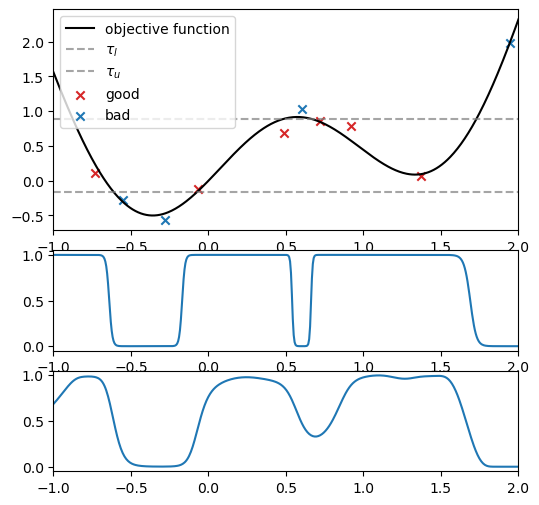

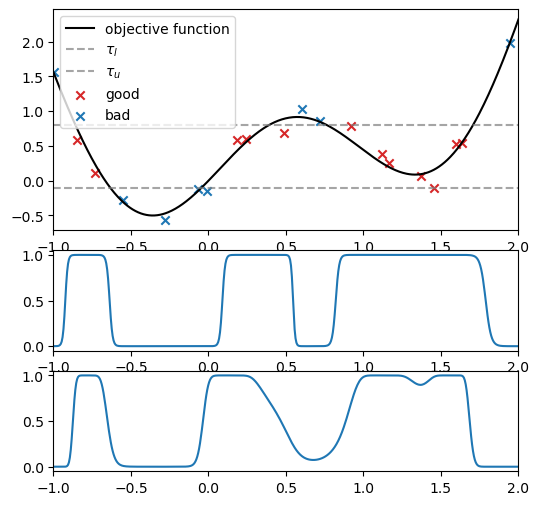

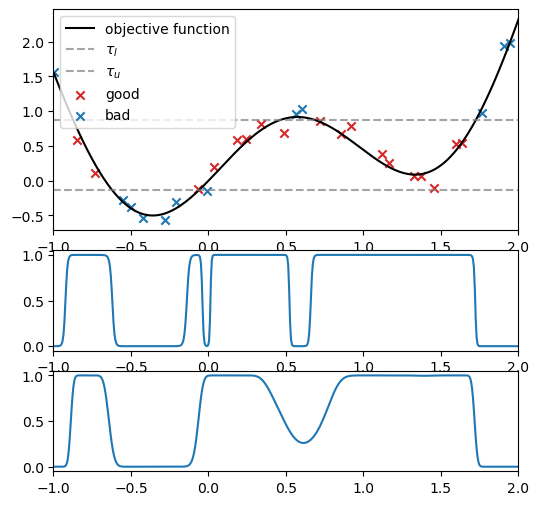

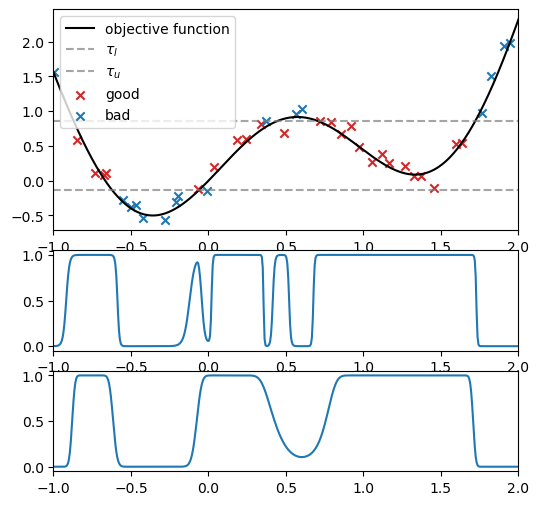

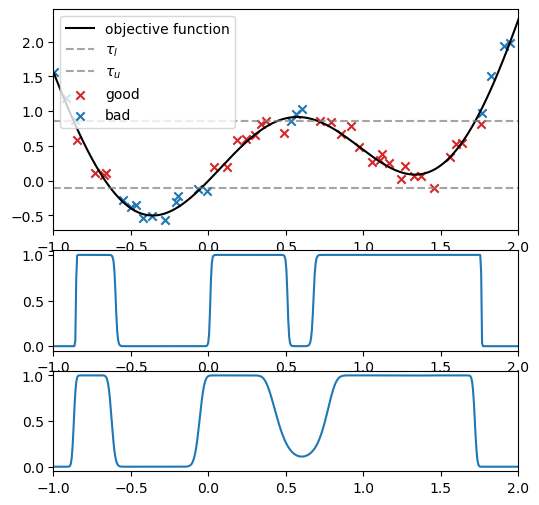

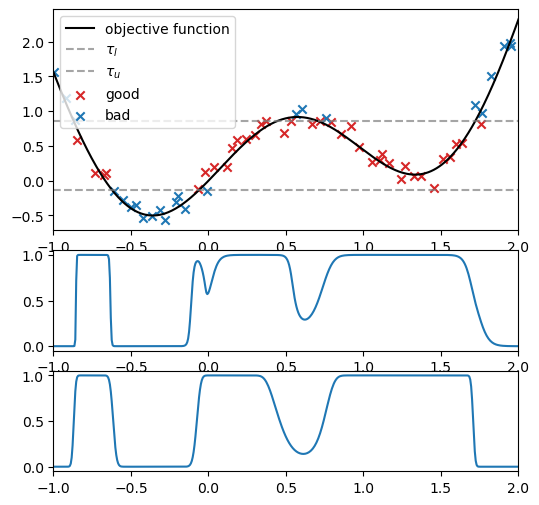

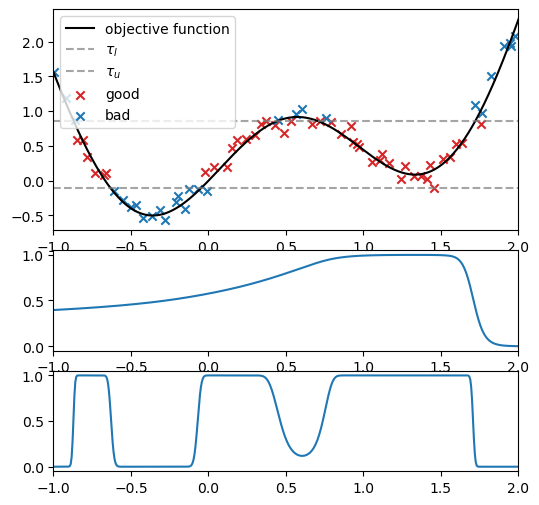

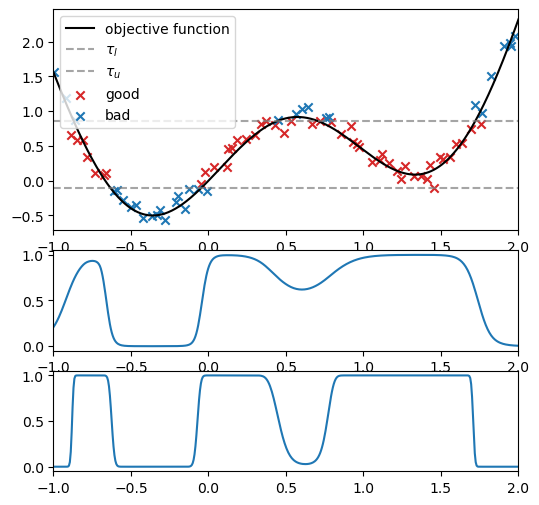

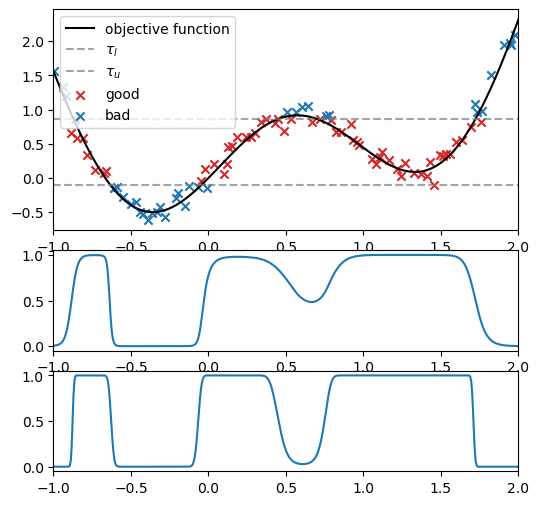

In [8]:
num_iter = 9
obs_start = 10
step = 10
x_dense_norm = normalize(x_dense, bounds)

for i in range(num_iter):
    tau_lower = torch.quantile(y_obs[:obs_start+i*step], q=gamma_lower)
    tau_upper = torch.quantile(y_obs[:obs_start+i*step], q=gamma_upper)

    lfbo = LFBO_C(input_dim=1, weight_type='pi')
    lfbo.fit(x_obs[:obs_start+i*step], y_obs[:obs_start+i*step], gamma_lower, gamma_upper, S=1000)
    acf = lfbo.predict(x_dense)
    # acf = acf / ((1 - acf) + 1e-10)

    # build a GP model scalarized objectives
    x_norm = normalize(x_obs[:obs_start+i*step], bounds)
    model = SingleTaskGP(
        x_norm, y_obs[:obs_start+i*step], outcome_transform=Standardize(m=1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    poi_lower = ProbabilityOfImprovement(model, best_f=tau_lower, maximize=False)
    poi_upper = ProbabilityOfImprovement(model, best_f=tau_upper, maximize=False)
    with torch.no_grad():
        poi = poi_upper(x_dense_norm.unsqueeze(1)) - poi_lower(x_dense_norm.unsqueeze(1))
    
    fig = plt.figure(figsize=(6, 6))

    ax_func = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
    ax_func.plot(x_dense, y_dense, color='k', label="objective function")

    ax_func.axhline(tau_lower, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau_l$')
    ax_func.axhline(tau_upper, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau_u$')

    x, y, z = split_good_bad(x_obs[:obs_start+i*step], y_obs[:obs_start+i*step], gamma_lower=gamma_lower, gamma_upper=gamma_upper)
    z = z.bool()
    ax_func.scatter(x[z], y[z], marker='x', color='tab:red', label="good")
    ax_func.scatter(x[~z], y[~z], marker='x', color='tab:blue', label="bad")
    ax_func.set_xlim(-1., 2.)
    ax_func.legend();

    ax_lfbo = plt.subplot2grid((4, 1), (2, 0), rowspan=1, sharex=ax_func)
    ax_lfbo.plot(
        x_dense,
        acf.reshape(x_dense.shape),
    )
    
    # ax_lfbo.set_ylim(0., 1.2)
    
    ax_gp = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax_func)
    ax_gp.plot(
        x_dense,
        poi.reshape(x_dense.shape),
    )
    # ax_gp.set_ylim(0., 1.2)
    # ax_lfbo.legend()
    plt.show()